# Complaint Resolution Times in Health Insurance Companies

### Load and clean the data

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adelanseur/insurance-company-complaints")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\ilvir\.cache\kagglehub\datasets\adelanseur\insurance-company-complaints\versions\1


In [8]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

dataset_file = os.path.join(path, "Insurance_Company_Complaints__Resolutions__Status__and_Recoveries.csv")

df = pd.read_csv(dataset_file)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (38267, 12)


,Company,File No.,Opened,Closed,Coverage,SubCoverage,Reason,SubReason,Disposition,Conclusion,Recovery,Status
0,"Anthem Health Plans, Inc",7045593,05/31/2022,06/02/2022,Group,Health Only,Claim Handling,Medically Necessary,Company Position Substantiated,Company Position Upheld,0.00,Closed
1,"Anthem Health Plans, Inc",7043381,02/28/2022,06/02/2022,Group,Health Only,Claim Handling,Provider Contract Issue,Claim Settled,Satisfied,6467.30,Closed
2,"Anthem Health Plans, Inc",7044860,05/03/2022,06/02/2022,A & H,Health Only,Claim Handling,Denial,Claim Settled,Claim Paid,147.58,Closed
3,"Anthem Health Plans, Inc",7043381,02/28/2022,06/02/2022,Group,A & H,Claim Handling,Provider Contract Issue,Claim Settled,Satisfied,6467.30,Closed
4,"Anthem Health Plans, Inc",7052007,02/23/2023,03/17/2023,A & H,A & H,Marketing & Sales,Duplicate Coverage,Compromised Settlement/Resolution,Premium Refund,2179.32,Closed


In [10]:
# Ensure the Opened and Closed columns are parsed as datetime
df['Opened'] = pd.to_datetime(df['Opened'], errors='coerce')
df['Closed'] = pd.to_datetime(df['Closed'], errors='coerce')

# Calculate the duration in days
df['Duration'] = (df['Closed'] - df['Opened']).dt.days

print(df[['Opened', 'Closed', 'Duration']].head())

      Opened     Closed  Duration
0 2022-05-31 2022-06-02       2.0
1 2022-02-28 2022-06-02      94.0
2 2022-05-03 2022-06-02      30.0
3 2022-02-28 2022-06-02      94.0
4 2023-02-23 2023-03-17      22.0


In [12]:
# Filter the DataFrame to keep only complaints with Status "Closed"
df = df[df['Status'].str.lower() == 'closed']

In [14]:
df.columns.tolist()

['Company',
 'File No.',
 'Opened',
 'Closed',
 'Coverage',
 'SubCoverage',
 'Reason',
 'SubReason',
 'Disposition',
 'Conclusion',
 'Recovery',
 'Status',
 'Duration']

In [16]:
# Remove unused columns
df = df.drop(columns=['File No.', 'Coverage', 'SubCoverage', 'Reason', 'SubReason',
                      'Disposition', 'Conclusion', 'Recovery', 'Status'])  

In [18]:
df.head()

,Company,Opened,Closed,Duration
0,"Anthem Health Plans, Inc",2022-05-31,2022-06-02,2.0
1,"Anthem Health Plans, Inc",2022-02-28,2022-06-02,94.0
2,"Anthem Health Plans, Inc",2022-05-03,2022-06-02,30.0
3,"Anthem Health Plans, Inc",2022-02-28,2022-06-02,94.0
4,"Anthem Health Plans, Inc",2023-02-23,2023-03-17,22.0


### EDA

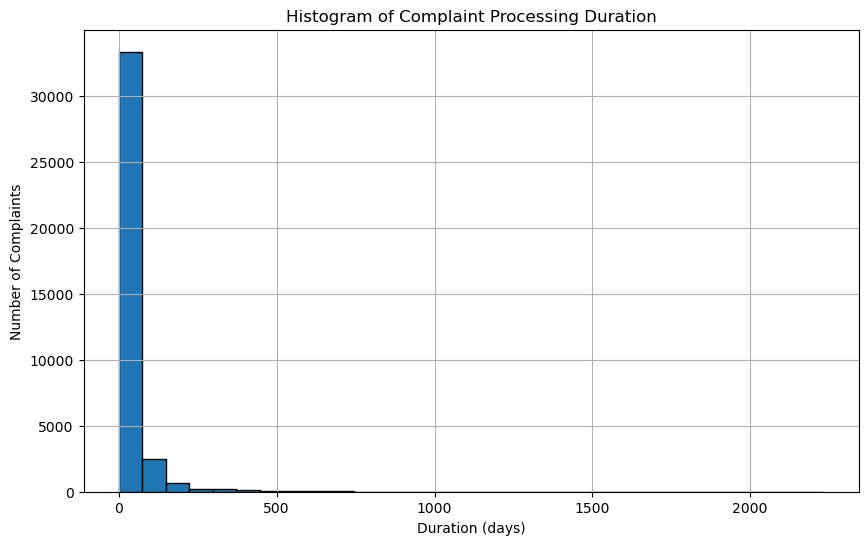

In [21]:
# Plot the histogram of complaint processing durations
plt.figure(figsize=(10, 6))
plt.hist(df['Duration'], bins=30, edgecolor='black')

plt.title('Histogram of Complaint Processing Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.show()


In [23]:
# Count unique companies
unique_companies = df['Company'].nunique()
print(f"Number of unique companies: {unique_companies}")

# Show the counts of each company
company_counts = df['Company'].value_counts()

print("\nTop companies by number of complaints:")
print(company_counts.head(10))  


Number of unique companies: 755

Top companies by number of complaints:
Company
Anthem Health Plans, Inc                          6435
ConnectiCare Benefits, Inc.                       1952
UnitedHealthcare Insurance Company                1503
ConnectiCare Insurance Company, Inc               1182
Cigna Health and Life Insurance Company           1135
Allstate Fire and Casualty Insurance Company       891
Oxford Health Plans (CT), Inc                      854
State Farm Mutual Automobile Insurance Company     775
Progressive Direct Insurance Company               768
ConnectiCare Inc                                   626
Name: count, dtype: int64


### What kind of distribution is it?

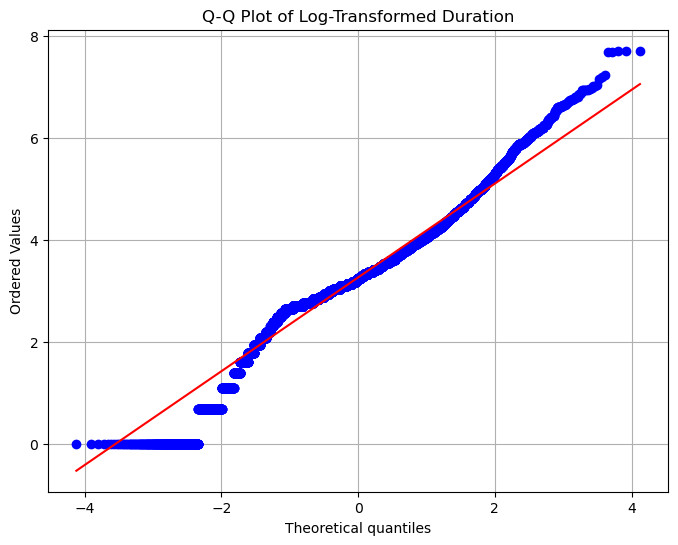

In [26]:
# Add a small constant to avoid log(0)
df['LogDuration'] = np.log(df['Duration'] + 1)

# Q-Q plot for log-transformed duration
plt.figure(figsize=(8, 6))
stats.probplot(df['LogDuration'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Duration')
plt.grid(True)
plt.show()


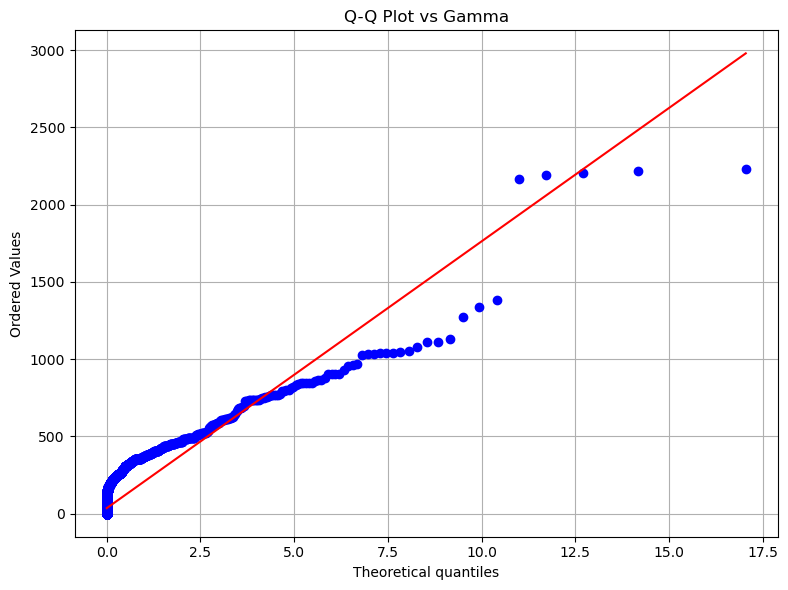

In [28]:
# Gamma distribution fitting
# Gamma is parameterized by shape (a), loc, scale
gamma_params = stats.gamma.fit(df['Duration'])

# Create Q-Q plot for Gamma
plt.figure(figsize=(8, 6))
stats.probplot(df['Duration'], dist="gamma", sparams=(gamma_params[0], gamma_params[1], gamma_params[2]), plot=plt)
plt.title('Q-Q Plot vs Gamma')
plt.grid(True)

plt.tight_layout()
plt.show()


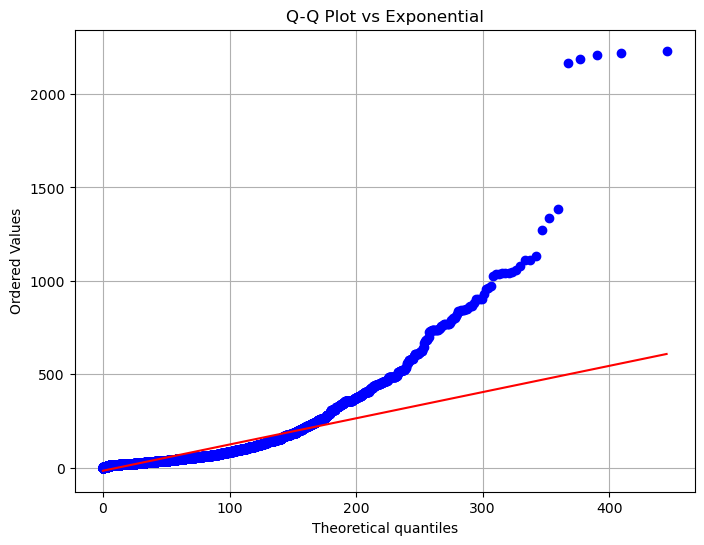

In [30]:
# Exponential distribution fitting
# Exponential is usually parameterized as loc + scale * Exponential
exp_params = stats.expon.fit(df['Duration'])

# Create Q-Q plot for Exponential
plt.figure(figsize=(8, 6))
stats.probplot(df['Duration'], dist="expon", sparams=(exp_params[0], exp_params[1]), plot=plt)
plt.title('Q-Q Plot vs Exponential')
plt.grid(True)

**Interpretation**:

- The Duration distribution doesn’t  fit log-normal, exponential or gamma either.

- There’s no exact standard distribution that perfectly matches the data.

### Confidence interval for the mean

In [34]:
# Basic statistics
n = len(df['Duration'])
mean_duration = np.mean(df['Duration'])
std_duration = np.std(df['Duration'], ddof=1)  # ddof=1 → sample standard deviation

print(f"Sample size: {n}")
print(f"Mean Duration: {mean_duration:.2f} days")
print(f"Standard Deviation: {std_duration:.2f} days")


Sample size: 37141
Mean Duration: 40.90 days
Standard Deviation: 68.66 days


#### Using Normal distribution

In [37]:
# 95% Confidence Level
confidence = 0.95
alpha = 1 - confidence

# Z critical value
z_critical = norm.ppf(1 - alpha/2)

# Margin of error
margin_of_error_normal = z_critical * (std_duration / np.sqrt(n))

# Confidence Interval
ci_normal = (mean_duration - margin_of_error_normal, mean_duration + margin_of_error_normal)

print(f"95% Confidence Interval for the mean (Normal): {ci_normal[0]:.2f} to {ci_normal[1]:.2f} days")


95% Confidence Interval for the mean (Normal): 40.20 to 41.60 days


#### Using t-distribution

In [40]:
from scipy.stats import t

# Degrees of freedom
dfree = n - 1

# t critical value
t_critical = t.ppf(1 - alpha/2, dfree)

# Margin of error
margin_of_error_t = t_critical * (std_duration / np.sqrt(n))

# Confidence Interval
ci_t = (mean_duration - margin_of_error_t, mean_duration + margin_of_error_t)

print(f"95% Confidence Interval for the mean (t-distribution): {ci_t[0]:.2f} to {ci_t[1]:.2f} days")


95% Confidence Interval for the mean (t-distribution): 40.20 to 41.60 days


**Interpretation:**

With 95% confidence, the true average complaint processing time is `between 40.2 and 41.6 days`.

### Confidence interval for the median

In [44]:
median_duration = np.median(df['Duration'])
print(f"Median Duration: {median_duration:.2f} days")


Median Duration: 24.00 days


#### Simple Percentile method 

In [47]:
# Sort the data
duration_sorted = np.sort(df['Duration'])

n = len(duration_sorted)
confidence = 0.95
alpha = 1 - confidence

# Lower and upper indices
lower_idx = int((alpha/2) * n)
upper_idx = int((1 - alpha/2) * n)

# Confidence Interval
ci_median_percentile = (duration_sorted[lower_idx], duration_sorted[upper_idx])

print(f"95% Confidence Interval for the median (Percentile method): {ci_median_percentile[0]:.2f} to {ci_median_percentile[1]:.2f} days")

95% Confidence Interval for the median (Percentile method): 2.00 to 185.00 days


**Interpretation:**

*Simple Percentile method* is very `rough and wide`.

With 95% confidence, the true median complaint processing time is `between 2 and 185 days` according to *Simple Percentile method*.

*Simple percentile method* is `too naive` and `not appropriate` for your real-world data. 


#### Bootstrap sampling

In [55]:
n_bootstrap = 100  # Number of bootstrap samples
bootstrap_medians = []

for _ in range(n_bootstrap):
    sample = np.random.choice(df['Duration'], size=1000, replace=True)
    bootstrap_medians.append(np.median(sample))

# Compute confidence interval
lower_bound = np.percentile(bootstrap_medians, 2.5)
upper_bound = np.percentile(bootstrap_medians, 97.5)

ci_median_bootstrap = (lower_bound, upper_bound)

print(f"95% Confidence Interval for the median (Bootstrap): {ci_median_bootstrap[0]:.2f} to {ci_median_bootstrap[1]:.2f} days")


95% Confidence Interval for the median (Bootstrap): 23.00 to 26.00 days


**Interpretation:**

With 95% confidence, the true median complaint processing time is `between 23 and 26 days.`

*Bootstrap method* captures the `real sampling behavior` of the median.

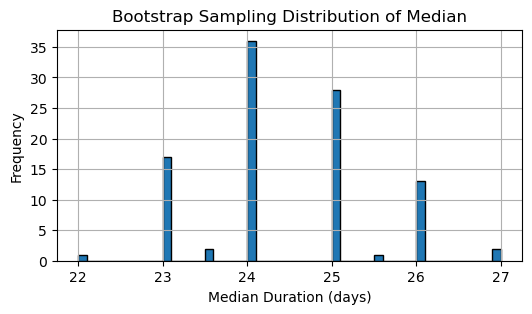

In [58]:
plt.figure(figsize=(6,3))
plt.hist(bootstrap_medians, bins=50, edgecolor='black')
plt.title('Bootstrap Sampling Distribution of Median')
plt.xlabel('Median Duration (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Group comparison

- Anthem Health Plans, Inc 
- ConnectiCare Benefits, Inc

In [61]:
# Filter for the two companies
companies_of_interest = ['Anthem Health Plans, Inc', 'ConnectiCare Benefits, Inc.']
df_filtered = df[df['Company'].isin(companies_of_interest)]

# Group by company and calculate mean and median Duration
group_stats = df_filtered.groupby('Company')['Duration'].agg(['count', 'mean', 'median', 'std'])

print(group_stats)


                             count       mean  median        std
Company                                                         
Anthem Health Plans, Inc      6435  40.169852    24.0  55.337571
ConnectiCare Benefits, Inc.   1952  39.604508    28.0  43.186273


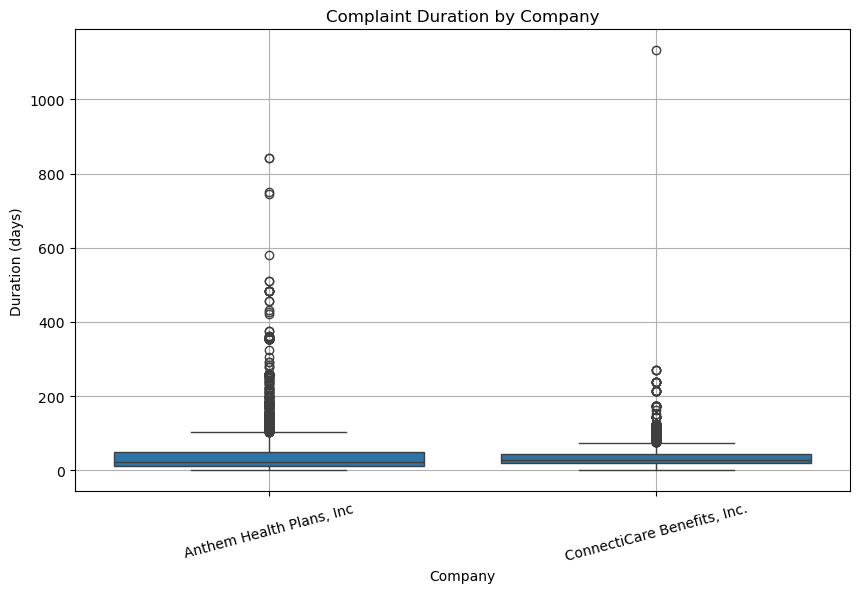

In [63]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_filtered, x='Company', y='Duration')
plt.title('Complaint Duration by Company')
plt.ylabel('Duration (days)')
plt.xticks(rotation=15)
plt.grid(True)
plt.show()


In [65]:
# Extract durations
duration_anthem = df_filtered[df_filtered['Company'] == 'Anthem Health Plans, Inc']['Duration']
duration_connecticare = df_filtered[df_filtered['Company'] == 'ConnectiCare Benefits, Inc.']['Duration']

# Mann-Whitney U Test
stat, p_value = mannwhitneyu(duration_anthem, duration_connecticare, alternative='two-sided')

print("\nMann-Whitney U Test result:")
print(f"Statistic = {stat:.2f}, p-value = {p_value:.4f}")

print("-----------------------------------------------------------------------------------------")

if p_value < 0.05:
    print("There is a significant difference between the two companies' complaint durations.")
else:
    print("No significant difference found between the two companies' complaint durations.")



Mann-Whitney U Test result:
Statistic = 5462832.00, p-value = 0.0000
-----------------------------------------------------------------------------------------
There is a significant difference between the two companies' complaint durations.


In [67]:
# bootstrap function
def bootstrap_median_ci(data, n_bootstrap=1000, confidence=0.95):
    n = len(data)
    medians = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        medians.append(np.median(sample))
    lower_bound = np.percentile(medians, (1 - confidence) / 2 * 100)
    upper_bound = np.percentile(medians, (1 + confidence) / 2 * 100)
    return (lower_bound, upper_bound)

# Durations for each company
duration_anthem = df_filtered[df_filtered['Company'] == 'Anthem Health Plans, Inc']['Duration']
duration_connecticare = df_filtered[df_filtered['Company'] == 'ConnectiCare Benefits, Inc.']['Duration']

# Bootstrap CIs
ci_anthem = bootstrap_median_ci(duration_anthem)
ci_connecticare = bootstrap_median_ci(duration_connecticare)

print(f"95% CI for Anthem Health Plans, Inc Median Duration: {ci_anthem[0]:.2f} to {ci_anthem[1]:.2f} days")
print(f"95% CI for ConnectiCare Benefits, Inc Median Duration: {ci_connecticare[0]:.2f} to {ci_connecticare[1]:.2f} days")


95% CI for Anthem Health Plans, Inc Median Duration: 23.00 to 25.00 days
95% CI for ConnectiCare Benefits, Inc Median Duration: 28.00 to 28.00 days


**Interpretation**:

On average, *Anthem resolves complaints faster* than ConnectiCare by approximately `3–5 days`, suggesting a potential *difference in operational efficiency* between the two companies.